In [67]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## Load Dataset

In [68]:
df = pd.read_excel("../data/raw/train.xlsx")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


## Feature Selection

In [69]:
TARGET = "price"

FEATURES = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "waterfront",
    "view",
    "condition",
    "grade",
    "sqft_above",
    "sqft_basement",
    "yr_built",
    "lat",
    "long",
    "sqft_living15",
    "sqft_lot15"
]

## Data Preparation

In [70]:
X = df[FEATURES].fillna(df[FEATURES].median())
y = df[TARGET]

## Train-validation split

In [71]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Baseline Model: Linear Regression

In [72]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [73]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [74]:
y_pred_lr = lin_reg.predict(X_val_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2_lr = r2_score(y_val, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R2:", r2_lr)

Linear Regression RMSE: 193064.8642878277
Linear Regression R2: 0.7029687257419828


## Improved Model: Random Forest

In [75]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [76]:
y_pred_rf = rf_model.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R2:", r2_rf)

Random Forest RMSE: 130138.00323328434
Random Forest R2: 0.8650403423468688


## Advance Model: XGBoost

In [77]:
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [78]:
y_pred_xgb = xgb_model.predict(X_val)

rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2_xgb = r2_score(y_val, y_pred_xgb)

rmse_xgb, r2_xgb

(np.float64(120336.86264815117), 0.8846033811569214)

In [79]:
## Model Performance Comparison

In [80]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [rmse_lr, rmse_rf, rmse_xgb],
    "R2": [r2_lr, r2_rf, r2_xgb]
})

results

,Model,RMSE,R2
0,Linear Regression,193064.864288,0.702969
1,Random Forest,130138.003233,0.865040
2,XGBoost,120336.862648,0.884603


In [81]:
## Feature Importance (XGBoost)

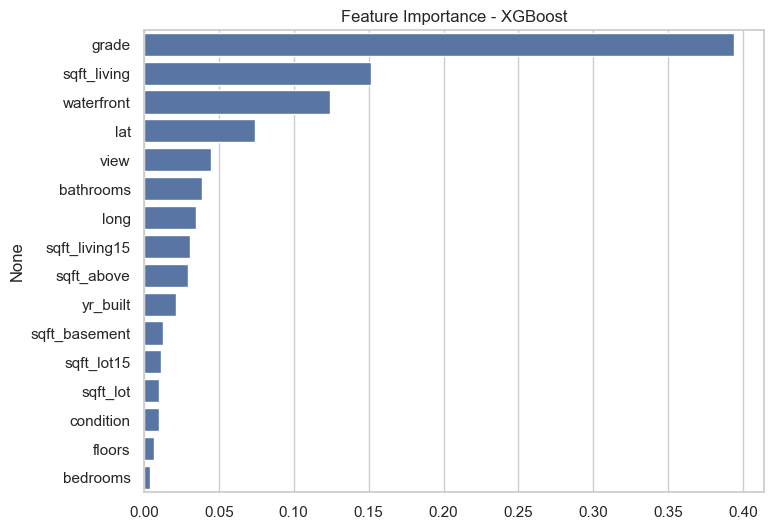

In [82]:
xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=xgb_importance.values, y=xgb_importance.index)
plt.title("Feature Importance - XGBoost")
plt.show()

## Key Takeaways

- Tree-based models outperform linear regression for tabular housing data.
- XGBoost achieves the best performance among tested models.
- Living area, construction grade, and neighborhood features are the strongest predictors.
- This tabular model serves as a strong baseline for multimodal learning.


## Save Trained Tabular Model

In [83]:
import joblib

In [84]:
joblib.dump(xgb_model, "../models/xgb_tabular_model.pkl")

['../models/xgb_tabular_model.pkl']

## Generate Predictions on Test Data

In [85]:
test_df = pd.read_excel("../data/raw/test.xlsx")

In [86]:
X_test = test_df[FEATURES].fillna(X.median())

In [87]:
test_predictions = xgb_model.predict(X_test)

In [88]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_predictions
})

submission.head()

,id,predicted_price
0,2591820310,3.848040e+05
1,7974200820,8.540678e+05
2,7701450110,1.057032e+06
3,9522300010,2.034852e+06
4,9510861140,7.544750e+05


In [89]:
submission.to_csv("../submission_tabular.csv", index=False)

In [90]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [91]:
train_df = pd.read_excel("../data/raw/train.xlsx")

In [92]:
image_embeddings = np.load("../data/embeddings/train_image_embeddings.npy")
image_ids = np.load("../data/embeddings/train_image_ids.npy")

In [93]:
print(image_embeddings.shape)
print(image_ids.shape)

(16133, 512)
(16133,)


In [94]:
image_df = pd.DataFrame(
    image_embeddings,
    columns=[f"img_{i}" for i in range(512)]
)

image_df["id"] = image_ids

# Deduplicate just in case
image_df = image_df.drop_duplicates(subset="id").reset_index(drop=True)

In [95]:
train_df_unique = train_df.drop_duplicates(subset="id").reset_index(drop=True)

In [140]:
merged_df = train_df_unique.merge(
    image_df,
    on="id",
    how="inner"
)

print("Merged rows:", len(merged_df))

Merged rows: 16034


In [125]:
TABULAR_FEATURES = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
    "waterfront", "view", "condition", "grade", "sqft_above",
    "sqft_basement", "yr_built", "lat", "long",
    "sqft_living15", "sqft_lot15"
]

In [126]:
IMG_FEATURES = [f"img_{i}" for i in range(512)]

In [127]:
X_tab = merged_df[TABULAR_FEATURES].fillna(
    merged_df[TABULAR_FEATURES].median()
).values

X_img = merged_df[IMG_FEATURES].values

y = merged_df["price"].values

In [128]:
print("Tabular:", X_tab.shape)
print("Image:", X_img.shape)
print("Target:", y.shape)

assert X_img.shape[1] == 512
assert X_tab.shape[0] == X_img.shape[0] == y.shape[0]

Tabular: (16034, 16)
Image: (16034, 512)
Target: (16034,)


In [129]:
X_tab_train, X_tab_val, \
X_img_train, X_img_val, \
y_train, y_val = train_test_split(
    X_tab,
    X_img,
    y,
    test_size=0.2,
    random_state=42
)

In [130]:
scaler = StandardScaler()

X_tab_train_scaled = scaler.fit_transform(X_tab_train)
X_tab_val_scaled = scaler.transform(X_tab_val)

In [131]:
xgb_img = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_img.fit(X_img_train, y_train)

y_pred_img = xgb_img.predict(X_img_val)

rmse_img = np.sqrt(mean_squared_error(y_val, y_pred_img))
r2_img = r2_score(y_val, y_pred_img)

print("Image-only RMSE:", rmse_img)
print("Image-only R²:", r2_img)

Image-only RMSE: 318995.31241696957
Image-only R²: 0.1433895230293274


In [132]:
X_train_mm = np.hstack([X_tab_train_scaled, X_img_train])
X_val_mm = np.hstack([X_tab_val_scaled, X_img_val])

print("Multimodal train shape:", X_train_mm.shape)
print("Multimodal val shape:", X_val_mm.shape)

Multimodal train shape: (12827, 528)
Multimodal val shape: (3207, 528)


In [133]:
xgb_mm = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_mm.fit(X_train_mm, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [134]:
y_pred_mm = xgb_mm.predict(X_val_mm)

In [135]:
rmse_mm = np.sqrt(mean_squared_error(y_val, y_pred_mm))
r2_mm = r2_score(y_val, y_pred_mm)

print("Multimodal RMSE:", rmse_mm)
print("Multimodal R²:", r2_mm)

Multimodal RMSE: 115952.7230555626
Multimodal R²: 0.8868181705474854


In [141]:
import joblib

joblib.dump(xgb_mm, "../models/xgb_multimodal_model.pkl")
joblib.dump(scaler, "../models/tabular_scaler.pkl")

['../models/tabular_scaler.pkl']

In [139]:
results = pd.DataFrame({
    "Model": [
        "Tabular Only",
        "Image Only",
        "Tabular + Image (Multimodal)"
    ],
    "RMSE": [
        rmse_xgb,
        rmse_img,
        rmse_mm
    ],
    "R2": [
        r2_xgb,
        r2_img,
        r2_mm
    ]
})

results

,Model,RMSE,R2
0,Tabular Only,120336.862648,0.884603
1,Image Only,318995.312417,0.143390
2,Tabular + Image (Multimodal),115952.723056,0.886818
